<a href="https://colab.research.google.com/github/Tverdostup1993/Python_for_ds_tasks/blob/main/%D0%A2%D0%B2%D0%B5%D1%80%D0%B4%D0%BE%D1%81%D1%82%D1%83%D0%BF_%D0%9E_%D0%86_%22HW_2_2_%D0%9B%D0%BE%D0%B3%D1%96%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%96%D1%8F_%D0%B7_scikit_learn_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle) Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [ ]:
?train_test_split

In [ ]:
X = train_df.drop(columns=['Exited'])
y = train_df['Exited']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [ ]:
target_col = 'Exited'
input_cols = [col for col in train_df.columns if col != target_col]

train_inputs = X_train[input_cols].copy()
val_inputs = X_val[input_cols].copy()
train_targets = y_train.copy()
val_targets = y_val.copy()

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [ ]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [ ]:
categorical_cols

['Surname', 'Geography', 'Gender']

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import set_config
import pandas as pd

# Щоб красиво показувало пайплайн
set_config(display='diagram')

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [ ]:
train_inputs_prepared = preprocessor.fit_transform(train_inputs)
val_inputs_prepared = preprocessor.transform(val_inputs)

In [ ]:
cat_encoded_cols = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols)
all_feature_names = numeric_cols + cat_encoded_cols.tolist()

# Створюємо датафрейми
train_inputs_df = pd.DataFrame(train_inputs_prepared, columns=all_feature_names)
val_inputs_df = pd.DataFrame(val_inputs_prepared, columns=all_feature_names)


In [ ]:
from IPython.display import display

print("Оброблені тренувальні дані:")
display(train_inputs_df.head())

print("Оброблені валідаційні дані:")
display(val_inputs_df.head())

Оброблені тренувальні дані:


,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_Zito,Surname_Zox,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.069136,-0.263441,0.320187,-0.944682,-1.447264,1.475464,-1.108193,0.515062,1.016977,0.569450,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.672227,-0.666919,0.347838,0.161227,-1.087792,2.254434,-1.108193,0.515062,-0.983306,0.603803,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-1.707380,0.569420,0.638166,-0.330288,0.350096,1.223831,0.769304,0.515062,-0.983306,1.238026,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.949404,0.610162,0.140460,2.495924,-1.806736,-0.717950,0.769304,-1.941514,1.016977,-1.457116,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.097479,-0.332313,0.665816,-2.050591,-0.728320,-0.717950,0.769304,0.515062,1.016977,0.670629,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Оброблені валідаційні дані:


,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_Zito,Surname_Zox,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.228346,0.703904,0.762592,1.021379,-1.447264,1.214543,4.524299,0.515062,1.016977,-0.988144,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.884566,-0.500773,-0.910252,0.406985,-0.009376,-0.717950,0.769304,0.515062,1.016977,-1.750392,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.501540,0.660086,0.997620,0.038348,-1.087792,-0.717950,0.769304,-1.941514,1.016977,-0.022404,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-1.575398,0.765385,0.195761,0.652742,-0.368848,1.881867,-1.108193,-1.941514,1.016977,-0.139723,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-1.119689,0.554699,0.264887,-0.944682,-0.368848,-0.717950,0.769304,0.515062,-0.983306,0.563519,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [ ]:
import os

In [ ]:
save_dir = 'prepared_data'

# Створюємо директорію
os.makedirs(save_dir, exist_ok=True)

In [ ]:
train_inputs.to_parquet(os.path.join(save_dir, 'train_inputs.parquet'))
train_targets.to_frame(name=target_col).to_parquet(os.path.join(save_dir, 'train_targets.parquet'))

val_inputs.to_parquet(os.path.join(save_dir, 'val_inputs.parquet'))
val_targets.to_frame(name=target_col).to_parquet(os.path.join(save_dir, 'val_targets.parquet'))


In [ ]:
!ls prepared_data

train_inputs.parquet   val_inputs.parquet
train_targets.parquet  val_targets.parquet


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [ ]:
X_train = train_inputs_prepared
X_val = val_inputs_prepared

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=42)

model.fit(X_train, train_targets)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
val_probs = model.predict_proba(X_val)[:, 1]  # беремо ймовірність класу 1

val_preds = model.predict(X_val)


7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    f1_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)
import matplotlib.pyplot as plt

Train Confusion Matrix:


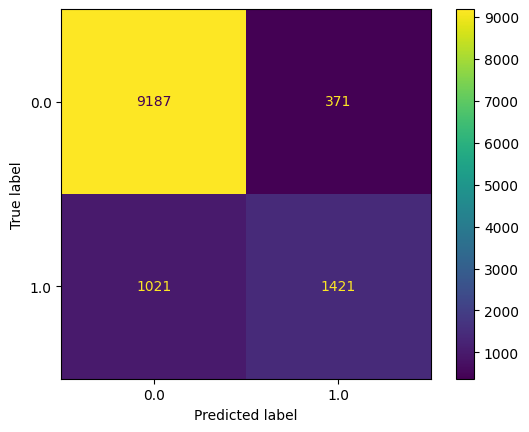

Train AUROC: 0.9020915282685528
Train F1 Score: 0.6712328767123288


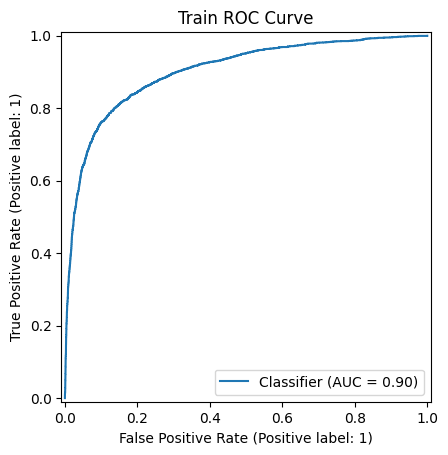

In [ ]:
# Прогнози
train_probs = model.predict_proba(X_train)[:, 1]
train_preds = (train_probs >= 0.5).astype(int)

# Метрики
print("Train Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(train_targets, train_preds)
plt.show()

print("Train AUROC:", roc_auc_score(train_targets, train_probs))
print("Train F1 Score:", f1_score(train_targets, train_preds))

# ROC крива
RocCurveDisplay.from_predictions(train_targets, train_probs)
plt.title("Train ROC Curve")
plt.show()


Validation Confusion Matrix:


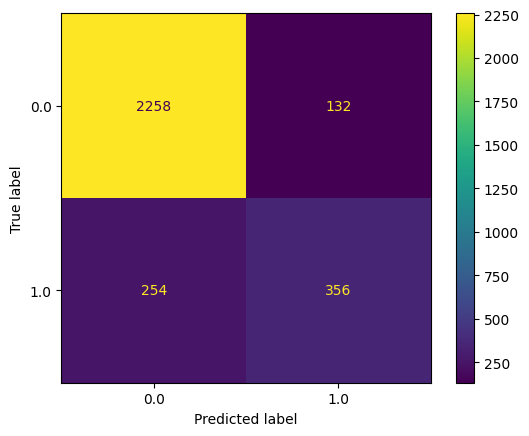

Validation AUROC: 0.8848329789423144
Validation F1 Score: 0.6484517304189436


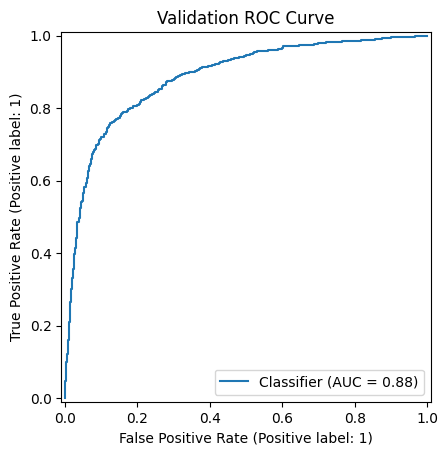

In [ ]:
val_preds = (val_probs >= 0.5).astype(int)

print("Validation Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(val_targets, val_preds)
plt.show()

print("Validation AUROC:", roc_auc_score(val_targets, val_probs))
print("Validation F1 Score:", f1_score(val_targets, val_preds))

RocCurveDisplay.from_predictions(val_targets, val_probs)
plt.title("Validation ROC Curve")
plt.show()


Модель — хороша. AUROC > 0.85 — це дуже сильний результат для логістичної регресії.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [ ]:
majority_class = train_targets.value_counts().idxmax()
print("Мажоритарний клас:", majority_class)

Мажоритарний клас: 0.0


In [ ]:
# Передбачення: завжди один і той самий клас
train_preds_majority = [majority_class] * len(train_targets)
val_preds_majority = [majority_class] * len(val_targets)

In [ ]:
from sklearn.metrics import accuracy_score

# Accuracy для мажоритарної моделі
train_acc_baseline = accuracy_score(train_targets, train_preds_majority)
val_acc_baseline = accuracy_score(val_targets, val_preds_majority)

# Accuracy для нашої логістичної регресії
train_acc_model = accuracy_score(train_targets, model.predict(X_train))
val_acc_model = accuracy_score(val_targets, model.predict(X_val))

# Вивід
print("Мажоритарна модель:")
print(f"Train Accuracy: {train_acc_baseline:.3f}")
print(f"Val Accuracy: {val_acc_baseline:.3f}")

print("Логістична регресія:")
print(f"Train Accuracy: {train_acc_model:.3f}")
print(f"Val Accuracy: {val_acc_model:.3f}")

Мажоритарна модель:
Train Accuracy: 0.796
Val Accuracy: 0.797
Логістична регресія:
Train Accuracy: 0.884
Val Accuracy: 0.871


Наша модель суттєво перевищує мажоритарну модель по Accuracy. Це свідчить, що модель вчиться, розрізняє класи, і працює краще, ніж просто вгадувати більшість.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [ ]:
import joblib

# Зберігаємо модель у файл
joblib.dump(model, 'log_reg.joblib')

['log_reg.joblib']

In [ ]:
joblib.dump(preprocessor, 'preprocessor.joblib')

['preprocessor.joblib']

In [ ]:
model_2 = joblib.load('log_reg.joblib')

In [ ]:
val_preds_loaded = model_2.predict(X_val)
print("F1 score з завантаженої моделі:", f1_score(val_targets, val_preds_loaded))

F1 score з завантаженої моделі: 0.6484517304189436


10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [ ]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, raw_df[:5])

In [ ]:
def predict_raw_df(preprocessor, model, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    # Копія, щоб не змінювати оригінальний DataFrame
    df = input_df.copy()

    # Застосовуємо препроцесинг (масштабування + кодування)
    X_transformed = preprocessor.transform(df)

    # Прогноз ймовірностей класу 1
    prob = model.predict_proba(X_transformed)[:, 1]

    return prob


In [ ]:
predict_raw_df(preprocessor, model, numeric_cols, categorical_cols, train_df[:5])

array([0.00476977, 0.0283023 , 0.60813103, 0.32310324, 0.97932256])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [ ]:
test_raw_df = pd.read_csv("test.csv")

In [ ]:
# Отримуємо ймовірності класу 1
test_probs = predict_raw_df(preprocessor, model, numeric_cols, categorical_cols, test_raw_df)

# Перетворюємо на передбачення (0 або 1)
test_raw_df['Exited'] = (test_probs >= 0.5).astype(int)

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [ ]:
print("Кількість рядків у sample_submission:", len(sample_submission))
print("Кількість рядків у test_raw_df:", len(test_raw_df))

Кількість рядків у sample_submission: 10000
Кількість рядків у test_raw_df: 10000


In [ ]:
sample_submission['Exited'] = test_raw_df['Exited']

In [ ]:
sample_submission.head()

,id,Exited
0,15000,0
1,15001,0
2,15002,0
3,15003,0
4,15004,0


In [ ]:
sample_submission.to_csv('submission_log_reg.csv', index=False)